In [2]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt


In [3]:
# Haar Cascade 불러오기
face_cascade = cv2.CascadeClassifier('/workspaces/Focussu-AI/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/workspaces/Focussu-AI/haarcascade_eye.xml')

In [4]:
# 이미지 불러오기
img = cv2.imread('/workspaces/Focussu-AI/data/NIA22EYE_S1_161_T1_S03_L_rgb_A_C_T_017.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [5]:
def show_image(title, image, cmap='gray'):
    plt.figure()
    plt.title(title)
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [6]:
iris_annotations = []  # iris 좌표 저장용
center_annotations = []  # 중심 좌표 저장용
eyelid_annotations = []  # 눈 바운딩 박스 저장용

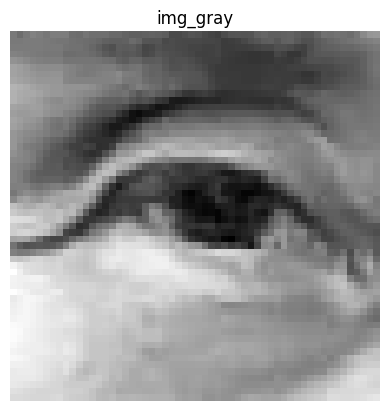

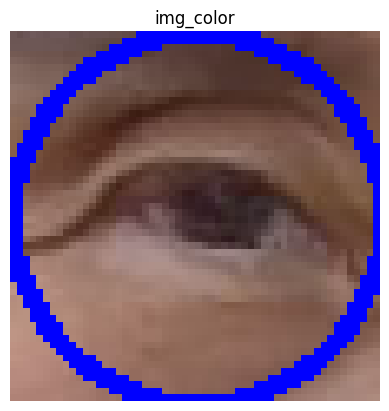

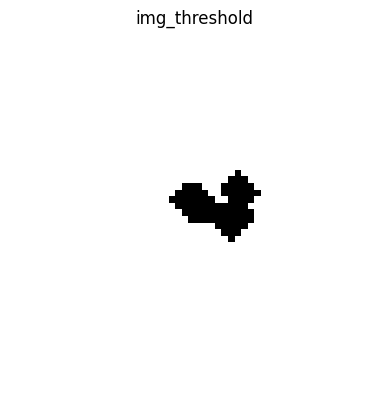

0.029336734693877552


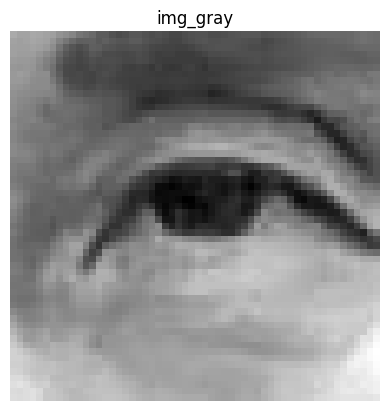

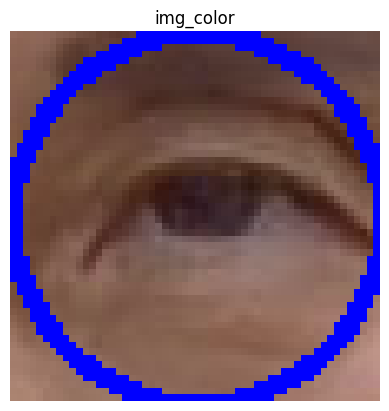

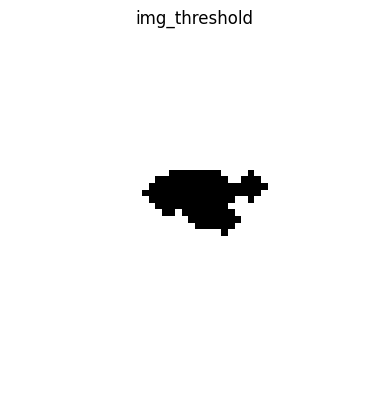

0.04145408163265306


In [7]:

# 이미지에서 얼굴부분 인식
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:

    # 얼굴의 위치를 사각형으로 표시 
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # 얼굴 인식 영역 내부에서만 눈 인식함
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.3, 5)

    eye_count = 0

    # 눈이 검출된 회수만큼 눈 좌표 읽기
    for (ex,ey,ew,eh) in eyes:
        eye_label = 'r' if eye_count == 0 else 'l'
        eye_count += 1
        # 원본 이미지에 눈의 위치 표시
        cv2.circle(roi_color,(ex+int(ew*0.5),ey+int(eh*0.5)),int(0.5*eh),(255,0,0),2)
        
        eye_gray = gray[y+ey:y+ey+eh, x+ex:x+ex+ew]
        eye_color = img[y+ey:y+ey+eh, x+ex:x+ex+ew]
        #gray 이미지에서 밝기가 30 이하인 부분만 추출한 것(동공이라고 보면된다.)
        _, threshold = cv2.threshold(eye_gray, 50, 255, cv2.THRESH_BINARY)

        # 노이즈 제거를 위한 모폴로지 연산
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

        # 침식 2회
        threshold_eroded = cv2.dilate(threshold, kernel, iterations=2)

        # 팽창 2회
        threshold_clean = cv2.erode(threshold_eroded, kernel, iterations=2)
        threshold = threshold_clean

        show_image('img_gray', eye_gray)

        show_image('img_color', eye_color, cmap=None)

        show_image('img_threshold', threshold)

        cv2.waitKey(0)
        cv2.destroyAllWindows()
       
        contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        #동공 부분 표기
        for contour in contours:
            ratio_area = cv2.contourArea(contour) / (eh * ew)
            print(ratio_area)
            if ratio_area:  # 동공이라고 판단되는 크기
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    radius = int(np.sqrt(cv2.contourArea(contour) / np.pi))
                    cv2.circle(eye_color, (cx, cy), radius, (0, 255, 0), 2) 

                    # iris (ellipse 형태)
                    iris_annotations.append({
                        "label": f"{eye_label}_iris",
                        "shape": "Ellipse",
                        "cx": x + ex + cx,
                        "cy": y + ey + cy,
                        "rx": radius,
                        "ry": radius,
                        "rotate": 0
                    })

                    # 중심 좌표
                    center_annotations.append({
                        "label": f"{eye_label}_center",
                        "shape": "Point",
                        "points": [[x + ex + cx, y + ey + cy]]
                    })

                    # eyelid (눈 사각형 영역을 polygon처럼)
                    eyelid_annotations.append({
                        "label": f"{eye_label}_eyelid",
                        "shape": "Polygon",
                        "points": [
                            [x + ex, y + ey],
                            [x + ex + ew, y + ey],
                            [x + ex + ew, y + ey + eh],
                            [x + ex, y + ey + eh]
                        ]
                    })
                break


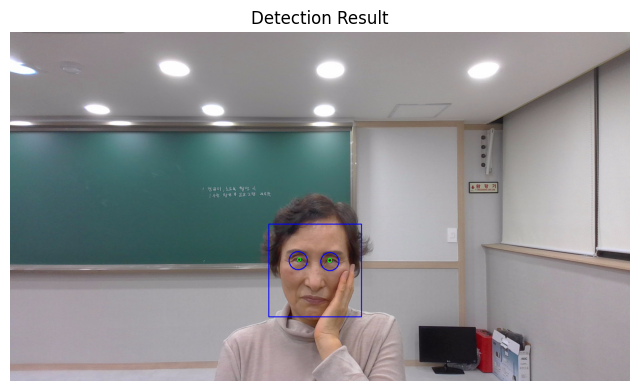

In [8]:
# BGR → RGB로 변환 (OpenCV는 BGR, matplotlib는 RGB 사용)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.title('Detection Result')
plt.axis('off')
plt.show()

In [ ]:
import json

annotations = {
    "name": ".png",  
    "annotations": iris_annotations + center_annotations + eyelid_annotations
}

# 예쁘게 출력
print(annotations)


{'name': 'image_name.png', 'annotations': [{'label': 'r_iris', 'shape': 'Ellipse', 'cx': 895, 'cy': 704, 'rx': 5, 'ry': 5, 'rotate': 0}, {'label': 'l_iris', 'shape': 'Ellipse', 'cx': 990, 'cy': 706, 'rx': 6, 'ry': 6, 'rotate': 0}, {'label': 'r_center', 'shape': 'Point', 'points': [[895, 704]]}, {'label': 'l_center', 'shape': 'Point', 'points': [[990, 706]]}, {'label': 'r_eyelid', 'shape': 'Polygon', 'points': [[864, 679], [920, 679], [920, 735], [864, 735]]}, {'label': 'l_eyelid', 'shape': 'Polygon', 'points': [[962, 682], [1018, 682], [1018, 738], [962, 738]]}]}
